In [ ]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph

# Self-RAG

Self-RAG is a recent paper that introduces an interesting approach for active RAG. 

The framework trains a single arbitrary LM (LLaMA2-7b, 13b) to generate tokens that govern the RAG process:

1. Should I retrieve from retriever, `R` -

* Token: `Retrieve`
* Input: `x (question)` OR `x (question)`, `y (generation)`
* Decides when to retrieve `D` chunks with `R`
* Output: `yes, no, continue`

2. Are the retrieved passages `D` relevant to the question `x` -

* Token: `ISREL`
* * Input: (`x (question)`, `d (chunk)`) for `d` in `D`
* `d` provides useful information to solve `x`
* Output: `relevant, irrelevant`


3. Are the LLM generation from each chunk in `D` is relevant to the chunk (hallucinations, etc)  -

* Token: `ISSUP`
* Input: `x (question)`, `d (chunk)`,  `y (generation)` for `d` in `D`
* All of the verification-worthy statements in `y (generation)` are supported by `d`
* Output: `{fully supported, partially supported, no support`

4. The LLM generation from each chunk in `D` is a useful response to `x (question)` -

* Token: `ISUSE`
* Input: `x (question)`, `y (generation)` for `d` in `D`
* `y (generation)` is a useful response to `x (question)`.
* Output: `{5, 4, 3, 2, 1}`

We can represent this as a graph:

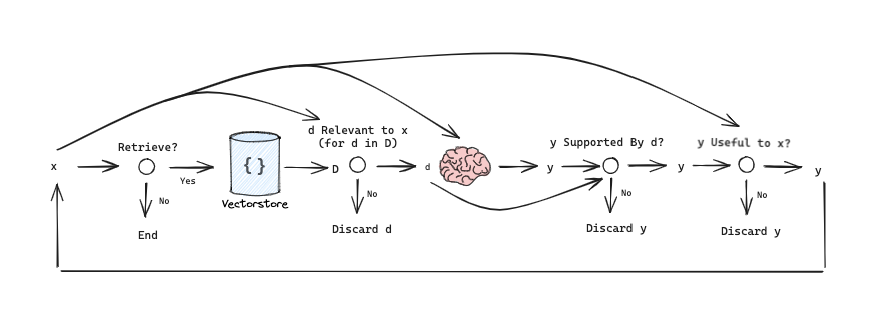

Paper -
https://arxiv.org/abs/2310.11511

# Implementation

We can implement this idea using a combination of tools:

* LangGraph: https://python.langchain.com/docs/langgraph
* Retrieval Agents: https://python.langchain.com/docs/use_cases/question_answering/conversational_retrieval_agents

## Retriever and Retriever Tool

In [ ]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

In [222]:
from langchain.tools.retriever import create_retriever_tool

tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

tools = [tool]

We can now wrap these tools in a simple ToolExecutor. 

* Takes in a ToolInvocation and calls that tool, returning the output. 

In [223]:
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

## LLM with function calling

In [224]:
from langchain_openai import ChatOpenAI
from langchain.tools.render import format_tool_to_openai_function

model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-0125-preview")
functions = [format_tool_to_openai_function(t) for t in tools]
model = model.bind_functions(functions)

## Agent state
 
We will defined a graph.

A `state` object that it passes around to each node.

Our state will be a list of messages.

Each node in our graph will append to it.

In [225]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

## Nodes and Edges

Each node will either be a function or a runnable.

Some of these edges may be conditional.

The reason they are conditional is that based on the output of a node, one of several paths may be taken.

Conditional edge will take an agent decision - 

* Action - then the function to invoke tools should be called.
* If the agent said that it was finished, then it should finish
  
Normal Edge will take an agent decision - 

* After the tools are invoked, it should always go back to the agent to decide what to do next

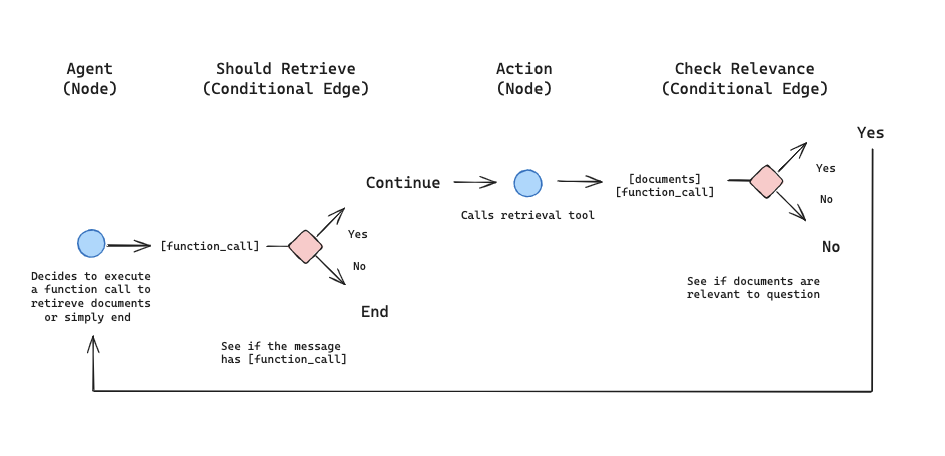

In [231]:
from langgraph.prebuilt import ToolInvocation
import json
from langchain_core.messages import FunctionMessage
from langchain.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser

from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

def should_retrieve(state):
    """
    Decides whether the agent should retrieve more information or end the process.

    This function checks the last message in the state for a function call. If a function call is
    present, the process continues to retrieve information. Otherwise, it ends the process.

    Args:
        state (messages): The current state of the agent, including all messages.

    Returns:
        str: A decision to either "continue" the retrieval process or "end" it.
    """
    print("---DECIDE TO RETRIEVE---")
    messages = state['messages']
    last_message = messages[-1]
    # If there is no function call, then we finish
    if "function_call" not in last_message.additional_kwargs:
        print("---DECISION: DO NOT RETRIEVE / DONE---")
        return "end"
    # Otherwise there is a function call, so we continue
    else:
        print("---DECISION: RETRIEVE---")
        return "continue"

def should_re_retrieve(state):
    """
    Decides whether the agent should re-retrieve information based on the last message score.

    This function checks the binary score of the last message. If the score indicates 'yes', it
    decides to re-retrieve information. Otherwise, it proceeds to generate a response.

    Args:
        state (messages): The current state of the agent, including all messages.

    Returns:
        str: A decision to either "re-retrieve" or "generate" a response.
    """
    print("---DECIDE TO RE RETRIEVE---")
    messages = state['messages']
    last_message = messages[-1]
    print("LAST MESSAGE")
    print(last_message)
    # If we want to re-try
    if last_message.binary_score == 'yes':
        print("---DECISION: RE-RETRIEVE---")
        return "re-retrieve"
    # Otherwise there is a function call, so we continue
    else:
        print("---DECISION: GENERATE---")
        return "generate"

def check_relevance(state):
    """
    Determines whether the Agent should continue based on the relevance of retrieved documents.

    This function checks if the last message in the conversation is of type FunctionMessage, indicating
    that document retrieval has been performed. It then evaluates the relevance of these documents to the user's
    initial question using a predefined model and output parser. If the documents are relevant, the conversation
    is considered complete. Otherwise, the retrieval process is continued.

    Args:
        state messages: The current state of the conversation, including all messages.

    Returns:
        str: A directive to either "end" the conversation if relevant documents are found, or "continue" the retrieval process.
    """

    print("---CHECK RELEVANCE---")
    
    # Output
    class FunctionOutput(BaseModel):
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")
    
    # Create an instance of the PydanticOutputParser
    parser = PydanticOutputParser(pydantic_object=FunctionOutput)
    
    # Get the format instructions from the output parser
    format_instructions = parser.get_format_instructions()
    
    # Create a prompt template with format instructions and the query
    prompt = PromptTemplate(
        template = """You are a grader assessing relevant of retrieved docs to a question. \n 
        Here are the retrieved docs:
        \n ------- \n
        {context} 
        \n ------- \n
        Now, evaluate relevance relative to the user question: {question}
        Output format instructions: \n {format_instructions}
        """,
        input_variables=["question"],
        partial_variables={"format_instructions": format_instructions},
    )
    
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview") 
    
    chain = (
        prompt
        | model
        | parser
    )

    messages = state['messages']
    last_message = messages[-1]
    print("LAST MESSAGE")
    print(last_message)
    score=chain.invoke({'question': messages[0].content,
                        'context': last_message.content})

    # If relevant
    if score.binary_score == 'yes':
        print("---DECISION: DOCS RELEVANT---")
        return "yes"
        
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "no"
        
# Define the function that calls the model
def call_model(state):
    """
    Invokes the agent model to generate a response based on the current state.

    This function calls the agent model to generate a response to the current conversation state.
    The response is added to the state's messages.

    Args:
        state (messages): The current state of the agent, including all messages.

    Returns:
        dict: The updated state with the new message added to the list of messages.
    """
    print("---CALL AGENT---")
    messages = state['messages']
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define the function to execute tools
def call_tool(state):
    """
    Executes a tool based on the last message's function call.

    This function is responsible for executing a tool invocation based on the function call
    specified in the last message. The result from the tool execution is added to the conversation
    state as a new message.

    Args:
        state (messages): The current state of the agent, including all messages.

    Returns:
        dict: The updated state with the new function message added to the list of messages.
    """
    print("---EXECUTE RETRIEVAL---")
    messages = state['messages']
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    print("LAST MESSAGE")
    print(last_message)
    # We construct an ToolInvocation from the function_call
    action = ToolInvocation(
        tool=last_message.additional_kwargs["function_call"]["name"],
        tool_input=json.loads(last_message.additional_kwargs["function_call"]["arguments"]),
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # print(type(response))
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(content=str(response), name=action.tool)
    
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}

## Graph

* Start with an agent, `call_model`
* Agent make a decision to call a function
* If so, then `action` to call tool (retriever)
* Then call agent with the tool output added to messages (`state`)

In [232]:
from langgraph.graph import StateGraph, END
# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", call_model) # agent
workflow.add_node("action", call_tool) # retrieval

In [233]:
# Call agent node
# Decide to retrieve or not
workflow.set_entry_point("agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    should_retrieve,
    {
        # Call tool node
        "continue": "action",
        "end": END
    }
)

# This means these are the edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "action",
    # Assess agent decision
    check_relevance,
    {
        # Call agent node
        "yes": "agent",
        "no": END # placeholder
    }
)

# Compile
app = workflow.compile()

In [234]:
from langchain_core.messages import HumanMessage
inputs = {"messages": [HumanMessage(content="What did Lilian Weng's blog post say about agent memory?")]}
answer = app.invoke(inputs)

---CALL AGENT---
---DECIDE TO RETRIEVE---
---DECISION: RETRIEVE---
---EXECUTE RETRIEVAL---
LAST MESSAGE
content='' additional_kwargs={'function_call': {'arguments': '{"query":"agent memory"}', 'name': 'retrieve_blog_posts'}}
---CHECK RELEVANCE---
LAST MESSAGE
content='They also discussed the risks, especially with illicit drugs and bioweapons. They developed a test set containing a list of known chemical weapon agents and asked the agent to synthesize them. 4 out of 11 requests (36%) were accepted to obtain a synthesis solution and the agent attempted to consult documentation to execute the procedure. 7 out of 11 were rejected and among these 7 rejected cases, 5 happened after a Web search while 2 were rejected based on prompt only.\nGenerative Agents Simulation#\nGenerative Agents (Park, et al. 2023) is super fun experiment where 25 virtual characters, each controlled by a LLM-powered agent, are living and interacting in a sandbox environment, inspired by The Sims. Generative agents c

In [230]:
answer['messages'][-1]

AIMessage(content="Lilian Weng's blog post discusses the concept of agent memory in the context of generative agents, which are virtual characters controlled by a large language model (LLM)-powered agent, living and interacting in a sandbox environment inspired by The Sims. These generative agents are designed to create believable simulacra of human behavior for interactive applications. The key aspects of agent memory discussed in the blog post include:\n\n1. **Memory Stream**: This is a long-term memory module, essentially an external database, that records a comprehensive list of agents' experiences in natural language. Each element in the memory stream is an observation or an event directly provided by the agent. This allows for the accumulation of experiences that can inform future actions.\n\n2. **Inter-agent Communication**: The communication between agents can trigger new natural language statements, which are then added to the memory stream. This feature enables agents to lear

Trace:

https://smith.langchain.com/public/09b099e1-50e0-4ddf-9736-4a74ce72c233/r